In [4]:
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt

In [5]:
def preprocess_data(data: pd.DataFrame):
    """预处理数据，计算指标"""
    data['RSI'] = ta.RSI(data['close'], timeperiod=14)
    data['volatility'] = data['close'].rolling(20).std()
    data['EMA26'] = data['close'].ewm(span=26, adjust=False).mean()
    data['EMA12'] = data['close'].ewm(span=12, adjust=False).mean()
    data['MACD'], data['Signal'], data['Hist'] = ta.MACD(data['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    # 金叉/死叉标记
    data['golden_cross'] = ((data['MACD'] > data['Signal']) & 
                        (data['MACD'].shift(1) <= data['Signal'].shift(1))).astype(int)
    data['death_cross'] = ((data['MACD'] < data['Signal']) & 
                        (data['MACD'].shift(1) >= data['Signal'].shift(1))).astype(int)

    # 最近N期的交叉情况
    for n in [3, 5, 10]:
        data[f'golden_cross_{n}d'] = data['golden_cross'].rolling(n).max()
        data[f'death_cross_{n}d'] = data['death_cross'].rolling(n).max()
    # 顶背离（价格新高但MACD未新高）
    data['price_peak'] = data['close'].rolling(5, center=True).max() == data['close']
    data['macd_peak'] = data['MACD'].rolling(5, center=True).max() == data['MACD']
    data['top_divergence'] = (data['price_peak'] & 
                            (data['MACD'] < data['MACD'].shift(3))).astype(int)

    # 底背离（价格新低但MACD未新低）
    data['price_valley'] = data['close'].rolling(5, center=True).min() == data['close']
    data['macd_valley'] = data['MACD'].rolling(5, center=True).min() == data['MACD']
    data['bottom_divergence'] = (data['price_valley'] & 
                                (data['MACD'] > data['MACD'].shift(3))).astype(int)

    # MACD线瞬时斜率
    data['macd_slope'] = data['MACD'].diff()
    # 移动平均斜率（捕捉趋势强度）
    for window in [3, 5, 10]:
        data[f'macd_slope_ma{window}'] = data['macd_slope'].rolling(window).mean()

    # MACD柱状图变化率
    data['hist_change_rate'] = data['Hist'].pct_change()

    # 量价配合特征
    data['macd_volume'] = data['MACD'] * data['volume'].pct_change(3)

    # 多周期MACD相关性
    data['macd_12_24_corr'] = data['MACD'].rolling(24).corr(data['MACD'].rolling(12).mean())
    return data.dropna()

In [6]:
data = pd.read_csv('stock.csv',parse_dates=['date'])
data = preprocess_data(data)
print(data.tail(20))


                      date     open    close      low     high        volume  \
129408 2025-03-14 12:00:00  1889.49  1893.42  1888.91  1896.84  5.275723e+05   
129409 2025-03-14 12:30:00  1893.06  1890.85  1890.71  1894.68  6.052042e+05   
129410 2025-03-14 13:00:00  1891.36  1893.93  1887.60  1894.95  5.507212e+05   
129411 2025-03-14 13:30:00  1894.30  1895.21  1893.70  1899.00  1.981229e+06   
129412 2025-03-14 14:00:00  1895.53  1889.60  1889.29  1896.44  4.269965e+05   
129413 2025-03-14 14:30:00  1890.00  1895.04  1888.47  1895.59  4.239161e+05   
129414 2025-03-14 15:00:00  1894.67  1893.09  1888.46  1894.67  3.645159e+05   
129415 2025-03-14 15:30:00  1893.06  1892.76  1890.41  1904.82  2.048504e+06   
129416 2025-03-14 16:00:00  1893.02  1898.26  1891.21  1902.50  8.929237e+05   
129417 2025-03-14 16:30:00  1898.60  1894.67  1891.56  1901.83  7.336112e+05   
129418 2025-03-14 17:00:00  1895.02  1897.59  1891.95  1898.68  6.134112e+05   
129419 2025-03-14 17:30:00  1898.25  189

In [7]:
# 背离信号有效性验证
# plt.figure(figsize=(14,6))
# plt.plot(data['close'][-1000:], label='Price')
# plt.scatter(data[data['top_divergence']==1].index[-30:], 
#            data['close'][data['top_divergence']==1][-30:], 
#            color='red', marker='v', s=100)
# plt.scatter(data[data['bottom_divergence']==1].index[-30:], 
#            data['close'][data['bottom_divergence']==1][-30:], 
#            color='green', marker='^', s=100)
# plt.title('Divergence Signals')
# plt.legend()
# plt.show()

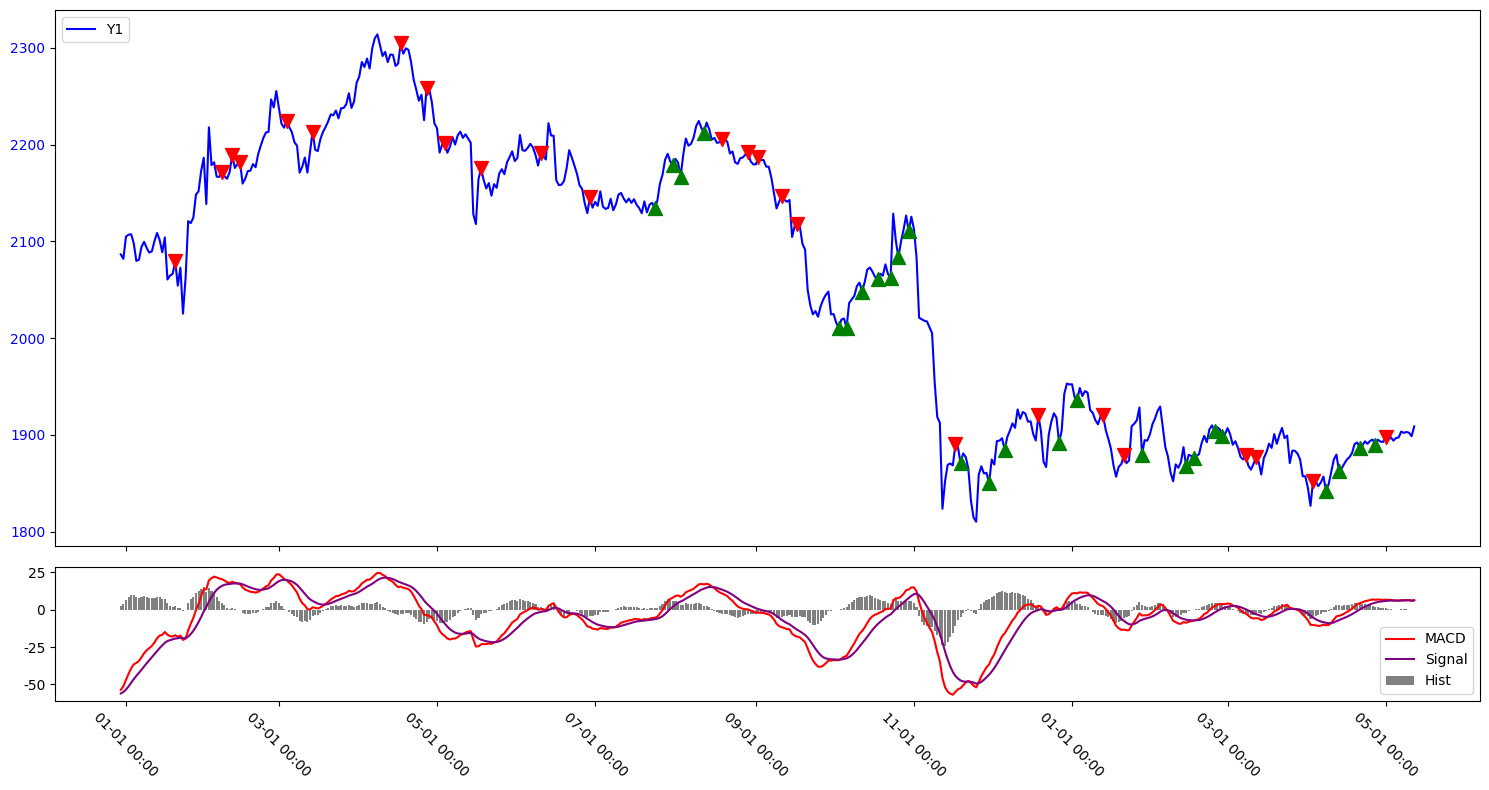

In [8]:
import matplotlib.dates as mdates
n = 500
plt.rcParams['font.sans-serif'] = ['SimHei','DejaVu Sans','Bitstream Vera Sans','Arial Serif','freeserif','sans-serif']
plt.rcParams['axes.unicode_minus'] = False

# subplots 2，1表示子图行数和列数，  figsize表示画布大小，sharex表示共享x轴, height_ratios表示子图高度比例
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8),height_ratios=[4, 1])
time_index = data.index[-n:]


date = data['date'].dt.strftime("%m-%d %H:%M")[-n:]
ax1.plot(time_index,data['close'][-n:],color='blue', label='Y1')

ax1.scatter(data[data['top_divergence']==1].index[-25:], 
           data['close'][data['top_divergence']==1][-25:], 
           color='red', marker='v', s=100, zorder=2)
ax1.scatter(data[data['bottom_divergence']==1].index[-25:], 
           data['close'][data['bottom_divergence']==1][-25:], 
           color='green', marker='^', s=100,zorder=2)
# ax1.set_ylabel("Y1轴", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

ax2.plot(time_index,data['MACD'][-n:], label='MACD', color='red')
ax2.plot(time_index,data['Signal'][-n:], label='Signal', color='purple')
ax2.bar(time_index, data['Hist'][-n:], color='gray', label='Hist')
ax2.tick_params(axis='y', left=True)

plt.legend()
# ax = plt.gca()
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
# 调整布局，腾出右侧空间
plt.subplots_adjust(right=0.85)
# 倾斜比例
plt.xticks(rotation=-45)
# plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.show()

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)
# 2. 特征工程
# 在特征工程中确保时间连续性
data['return_lag3'] = data['close'].pct_change(3)

features = ['close', 'volume', 'MACD', 'Signal', 'Hist','volatility']
enhanced_features = features + [
    'golden_cross_3d', 'death_cross_3d',
    'top_divergence', 'bottom_divergence',
    'macd_slope_ma5', 'hist_change_rate'
]
# 确保所有特征有效存在
assert all(col in data.columns for col in enhanced_features), \
    "存在无效特征列，请检查特征生成代码"
print("DataFrame列名:", data.columns.tolist())
print("增强特征列表:", enhanced_features)
# 检查数据维度
print(f"特征矩阵维度: {data[enhanced_features].shape}")
print(f"增强特征数量: {len(enhanced_features)}")

X = data[enhanced_features].shift(1)
y = data['close'].shift(-1)  # 与X保持相同的shift方向

# 同时丢弃首尾无效行
valid_mask = X.notna().all(axis=1) & y.notna()
X = X[valid_mask]
y = y[valid_mask].gt(data['close'].shift(0)[valid_mask]).astype(int)  # 比较当前价  # 次日上涨标记为1
print(f"X shape: {X.shape}, y shape: {y.shape}")
# 3. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, shuffle=False)


# 4. 训练模型
model = RandomForestClassifier(n_estimators=500,max_depth=10,
    class_weight='balanced',
    random_state=42)
for train_index, test_index in tscv.split(X):
    model.fit(X.iloc[train_index], y.iloc[train_index])
    model.n_estimators += 50 
# model.fit(X_train, y_train)
# pd.Series(model.feature_importances_, index=enhanced_features).sort_values().plot.barh() 
# 5. 预测与评估
predictions = model.predict(X_test)
accuracy = (predictions == y_test.values).mean()
print(f"Accuracy: {accuracy:.2f}")

print("AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

DataFrame列名: ['date', 'open', 'close', 'low', 'high', 'volume', 'count', 'amount', 'RSI', 'volatility', 'EMA26', 'EMA12', 'MACD', 'Signal', 'Hist', 'golden_cross', 'death_cross', 'golden_cross_3d', 'death_cross_3d', 'golden_cross_5d', 'death_cross_5d', 'golden_cross_10d', 'death_cross_10d', 'price_peak', 'macd_peak', 'top_divergence', 'price_valley', 'macd_valley', 'bottom_divergence', 'macd_slope', 'macd_slope_ma3', 'macd_slope_ma5', 'macd_slope_ma10', 'hist_change_rate', 'macd_volume', 'macd_12_24_corr', 'return_lag3']
增强特征列表: ['close', 'volume', 'MACD', 'Signal', 'Hist', 'volatility', 'golden_cross_3d', 'death_cross_3d', 'top_divergence', 'bottom_divergence', 'macd_slope_ma5', 'hist_change_rate']
特征矩阵维度: (129355, 12)
增强特征数量: 12
X shape: (129353, 12), y shape: (129353,)
Accuracy: 0.54
AUC: 0.5639176461986757


DataFrame列名: ['date', 'open', 'close', 'low', 'high', 'volume', 'count', 'amount', 'RSI', 'volatility', 'EMA26', 'EMA12', 'MACD', 'Signal', 'Hist', 'golden_cross', 'death_cross', 'golden_cross_3d', 'death_cross_3d', 'golden_cross_5d', 'death_cross_5d', 'golden_cross_10d', 'death_cross_10d', 'price_peak', 'macd_peak', 'top_divergence', 'price_valley', 'macd_valley', 'bottom_divergence', 'macd_slope', 'macd_slope_ma3', 'macd_slope_ma5', 'macd_slope_ma10', 'hist_change_rate', 'macd_volume', 'macd_12_24_corr', 'return_lag3']
增强特征列表: ['close', 'volume', 'MACD', 'Signal', 'Hist', 'volatility', 'golden_cross_3d', 'death_cross_3d', 'top_divergence', 'bottom_divergence', 'macd_slope_ma5', 'hist_change_rate']
特征矩阵维度: (129355, 12)
增强特征数量: 12
      close        volume      MACD    Signal      Hist  volatility  \
67  1933.23  3.169031e+05  2.692220  3.814346 -1.122126    5.481362   
68  1929.90  1.051369e+06  1.730418  3.397560 -1.667142    5.635046   
69  1924.59  7.488177e+05  0.533560  2.824760 

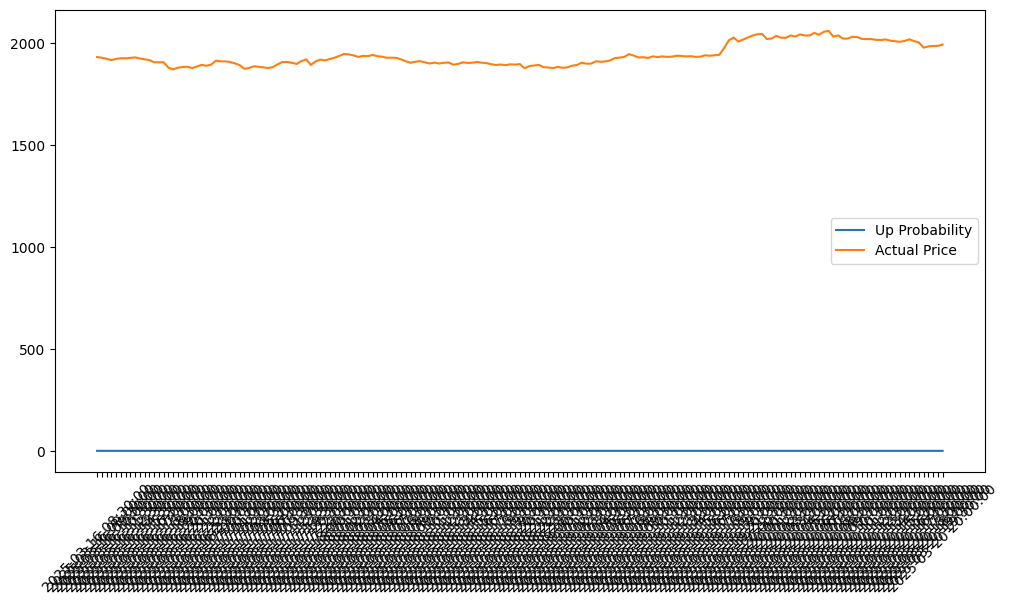

In [27]:
# print(data.describe().transpose())
# 2025-03-14 22:00:00
new_data = preprocess_data(pd.read_csv('new_stock.csv', parse_dates=True))


features = ['close', 'volume', 'MACD', 'Signal', 'Hist','volatility']
enhanced_features = features + [
    'golden_cross_3d', 'death_cross_3d',
    'top_divergence', 'bottom_divergence',
    'macd_slope_ma5', 'hist_change_rate'
]
assert all(col in new_data.columns for col in enhanced_features), \
    f"缺失特征: {set(enhanced_features)-set(new_data.columns)}"
# 确保所有特征有效存在
assert all(col in data.columns for col in enhanced_features), \
    "存在无效特征列，请检查特征生成代码"
print("DataFrame列名:", data.columns.tolist())
print("增强特征列表:", enhanced_features)
# 检查数据维度
print(f"特征矩阵维度: {data[enhanced_features].shape}")
print(f"增强特征数量: {len(enhanced_features)}")
X_new = new_data[enhanced_features]
# 处理缺失值
X_new = X_new.dropna()
print(X_new.head())

predictions = model.predict(X_new)
pred_proba = model.predict_proba(X_new)[:,1]  # 获取正类概率
print("pre_proba: -------->", pred_proba)
print("预测结果:", predictions)
# 若新数据有真实标签
if 'close' in new_data:
    y_new = (new_data['close'].shift(-1) > new_data['close']).astype(int)
    y_new = y_new.loc[X_new.index]
    
    accuracy = (predictions == y_new).mean()
    auc = roc_auc_score(y_new, pred_proba)
    print(f"New Data Accuracy: {accuracy:.2%}")
    print(f"New Data AUC: {auc:.4f}")

# 绘制实际走势与预测结果对比
plt.figure(figsize=(12,6))
plt.plot(new_data['date'].iloc[-len(predictions):], pred_proba, label='Up Probability')
plt.plot(new_data['date'].iloc[-len(predictions):], new_data['close'].iloc[-len(predictions):], 
         label='Actual Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()